In [1]:
import numpy as np
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
import scipy
import skimage as sk
from skimage import color
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import h5py
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten, Reshape, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Input
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9942497483016937354
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7680170394
locality {
  bus_id: 1
}
incarnation: 11888406866110438206
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


# Load Datasets

Loads the SVHN and MNIST datasets. We'll be building a binary classifier that classifies an image as part of the MNIST dataset or SVHN dataset. 

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_train_X = mnist.train.images
mnist_test_X = mnist.test.images
mnist_train_y = mnist.train.labels
mnist_test_y = mnist.test.labels

In [5]:
svhn_train = scio.loadmat('svhn_train.mat')
svhn_test = scio.loadmat('svhn_test.mat')

In [6]:
svhn_train_X = svhn_train['X']
svhn_train_y = svhn_train['y']
svhn_test_X = svhn_test['X']
svhn_test_y = svhn_test['y']
encoder = OneHotEncoder()
svhn_train_y = encoder.fit_transform(svhn_train_y).todense()
svhn_test_y = encoder.fit_transform(svhn_test_y).todense()

# Preprocessing

In [7]:
def resize_images(imgs):
    return np.array([sk.img_as_float(scipy.misc.imresize(img.reshape(28, 28), (32, 32))) for img in imgs])

In [8]:
svhn_train_X = np.array([sk.img_as_float(scipy.misc.imresize(svhn_train_X[:, :, :, i], (32, 32, 3))) for i in range(svhn_train_X.shape[-1])])
svhn_test_X = np.array([sk.img_as_float(scipy.misc.imresize(svhn_test_X[:, :, :, i], (32, 32, 3))) for i in range(svhn_test_X.shape[-1])])

In [9]:
mnist_train_X = resize_images(mnist_train_X).reshape(mnist_train_X.shape[0], 32, 32, 1)
mnist_test_X = resize_images(mnist_test_X).reshape(mnist_test_X.shape[0], 32, 32, 1)

In [10]:
stacked_mnist_train_X = np.stack((mnist_train_X, mnist_train_X, mnist_train_X), axis=3).reshape(mnist_train_X.shape[0], 32, 32, 3)
stacked_mnist_test_X = np.stack((mnist_test_X, mnist_test_X, mnist_test_X), axis=3).reshape(mnist_test_X.shape[0], 32, 32, 3)

# MNIST & SVHN Classifier: f
We define a classifier for both MNIST and SVHN for our cross domain mapping.

In [12]:
def f_model(pretrain=True):
    f = Sequential([
        Conv2D(64, (3, 3), input_shape=(32, 32, 3), padding='same'), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('relu'),
        Conv2D(128, (3, 3)), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('relu'),
        Conv2D(256, (3, 3)), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('tanh'),
        Conv2D(128, (4, 4), padding='same'),
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('tanh'),
    ])
    if pretrain:
        f.add(Conv2D(10, (1, 1)))
        f.add(Activation('softmax'))
        f.add(Flatten())
    return f

### Initialize f

In [13]:
f = f_model()
f.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [14]:
X_train = np.vstack((stacked_mnist_train_X, svhn_train_X))
X_test = np.vstack((stacked_mnist_test_X, svhn_test_X))
y_train = np.vstack((mnist_train_y, svhn_train_y))
y_test = np.vstack((mnist_test_y, svhn_test_y))
X_train, y_train = skl.utils.shuffle(X_train, y_train)
X_test, y_test = skl.utils.shuffle(X_test, y_test)

In [ ]:
f.fit(X_train, y_train, epochs=2)

In [15]:
f.load_weights('fweights.h5')

### Validation

In [16]:
f.evaluate(X_test, y_test)

35872/36032 [============================>.] - ETA: 0s

[0.29354892199657207, 0.91393761101243343]

# Generator: g


In [17]:
def g_model():
    return Sequential([
        Conv2DTranspose(512, (4, 4), input_shape=(1, 1, 128), kernel_initializer='truncated_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(256, (5, 5), kernel_initializer='truncated_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(128, (9, 9), kernel_initializer='truncated_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(1, (17, 17), kernel_initializer='truncated_normal'),
        Activation('tanh'),
    ])

def extract_f(f_classifier):
    f = Sequential()
    for i in range(13):
        f.add(f_classifier.get_layer(index=i))
    return f

def discriminator():
    return Sequential([
        Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 1), kernel_initializer='truncated_normal'),
        BatchNormalization(),  
        Activation('relu'),
        Conv2D(256, (3, 3), padding='same', kernel_initializer='glorot_normal'),
        BatchNormalization(),  
        Activation('relu'),
        Conv2D(512, (3, 3), padding='same', kernel_initializer='glorot_normal'),
        BatchNormalization(),  
        Activation('relu'),
        Conv2D(1, (4, 4), padding='valid', kernel_initializer='truncated_normal'),
        Activation('relu'),
        Flatten(),
        Dense(1),
        Activation('sigmoid'),
    ])
    
def generator(f, g):
    f.trainable = False
    f_input = Input(shape=svhn_train_X[0].shape)
    x = f(f_input)
    g_output = g(x)
    G = Model(inputs=f_input, outputs=g_output)
    return G

def trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [37]:
g = g_model()
f_baseline = extract_f(f)
f_baseline.compile(optimizer='sgd', loss='categorical_crossentropy')
G = generator(f_baseline, g)
D = discriminator()

In [ ]:
G.load_weights('G.h5')
D.load_weights('D.h5')

# Training G and D

In [38]:
def train(g, d, mnist_X, svhn_X, epochs=1):
    for i in range(2000):
        # Create batches
        batch_mnist_X = mnist_X[np.random.randint(mnist_X.shape[0], size=100)] 
        batch_svhn_X = svhn_X[np.random.randint(svhn_X.shape[0], size=100)]
        
        print('Iteration {}'.format(i))
        # Generate MNIST examples for SVHN for training
        g_train_data = g.predict(batch_svhn_X)
        
        # Label as real or fake 
        real_labels, fake_labels = np.zeros(100), np.ones(100)
        train_data, train_labels = np.vstack((batch_mnist_X, g_train_data)), np.hstack((real_labels, fake_labels))
        train_data, train_labels = skl.utils.shuffle(train_data, train_labels)
        
        # Train discriminator on this real/fake data
        print('Training Discriminator')
        d.trainable = True
        d.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
#         print(d.get_weights())
        d.fit(train_data, train_labels, batch_size=100, epochs=2)
      
        # Train generator based on the outputs of the discriminator
        print('Training Generator')
        g_d = generator_with_discriminator(g, d)
        g_d.compile(loss=loss_function(batch_svhn_X, g), optimizer='adam', metrics=['accuracy'])
        g_d.fit(batch_svhn_X, np.zeros(batch_svhn_X.shape[0]), batch_size=100, epochs=4)
        
#         g.save_weights('G.h5')
#         d.save_weights('D.h5')
    return g, d

def loss_function(svhn_X, g):
    class_true = f.predict(svhn_X)
    def loss(y_true, y_pred):
        preds = g.predict(svhn_X)
        stacked_preds = np.stack((preds, preds, preds), axis=3).reshape(preds.shape[0], 32, 32, 3)
        class_pred = f.predict(stacked_preds)
        loss_gan = keras.losses.mean_squared_error(y_true, y_pred)
        loss_const = keras.losses.mean_squared_error(class_true, class_pred)
        return 0.5 * loss_gan + 5 * loss_const
    return loss

def generator_with_discriminator(g, d):
    d.trainable = False
    gan_input = Input(shape=svhn_train_X[0].shape)
    x = g(gan_input)
    gan_output = d(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

In [ ]:
G, D = train(G, D, mnist_test_X[:10000], svhn_test_X[:10000])

Iteration 0
Training Discriminator
Epoch 1/2
200/200 [==============================] - 3s - loss: 5.9955 - acc: 0.5000     
Epoch 2/2
200/200 [==============================] - 0s - loss: 7.9823 - acc: 0.5000     
Training Generator
Epoch 1/4
100/100 [==============================] - 3s - loss: 1.0745 - acc: 0.0000e+00
Epoch 2/4
100/100 [==============================] - 0s - loss: 1.0745 - acc: 0.0000e+00
Epoch 3/4
100/100 [==============================] - 0s - loss: 1.0745 - acc: 0.0000e+00
Epoch 4/4
100/100 [==============================] - 0s - loss: 1.0745 - acc: 0.0000e+00
Iteration 1
Training Discriminator
Epoch 1/2
200/200 [==============================] - 3s - loss: 7.9842 - acc: 0.5000     
Epoch 2/2
200/200 [==============================] - 0s - loss: 7.9801 - acc: 0.5000     
Training Generator
Epoch 1/4
100/100 [==============================] - 3s - loss: 1.0901 - acc: 0.0000e+00
Epoch 2/4
100/100 [==============================] - 0s - loss: 1.0872 - acc: 0.0000e+0

array([[  3.26918644e-06],
       [  2.88577144e-06],
       [  2.16660715e-06],
       [  2.06453228e-06],
       [  1.95253801e-06],
       [  2.10311441e-06],
       [  3.43345619e-06],
       [  1.57338150e-06],
       [  1.28516399e-06],
       [  3.21161292e-06]], dtype=float32)

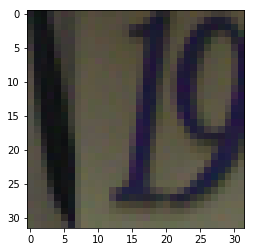

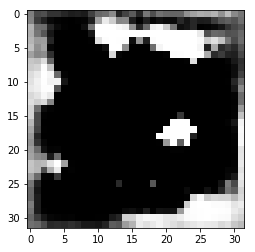

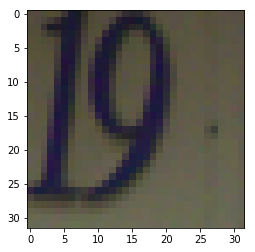

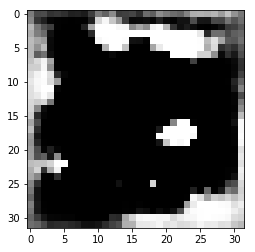

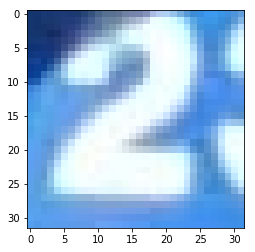

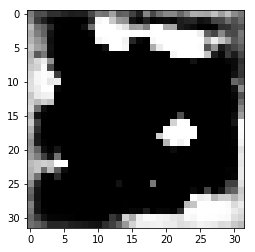

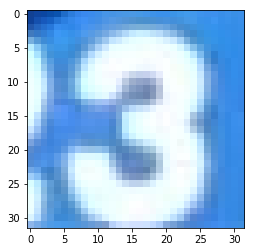

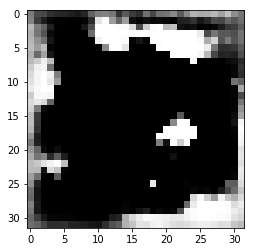

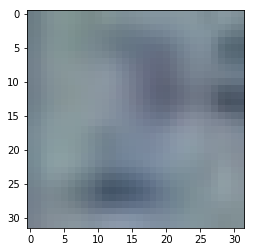

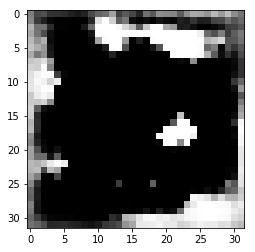

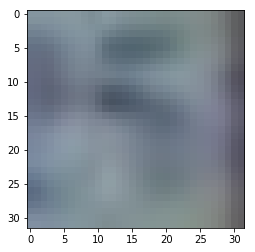

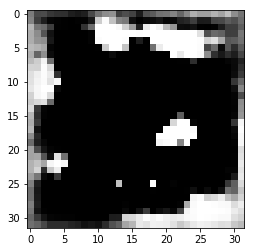

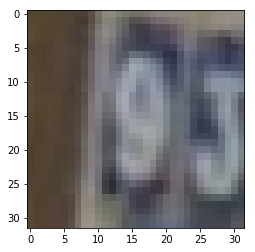

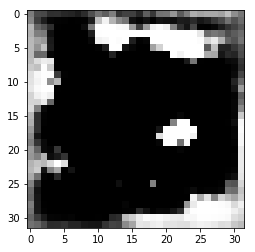

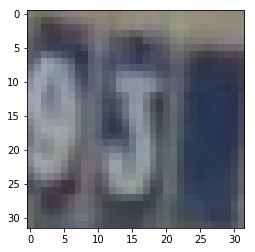

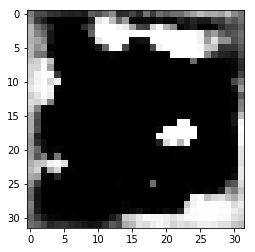

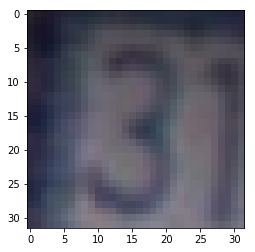

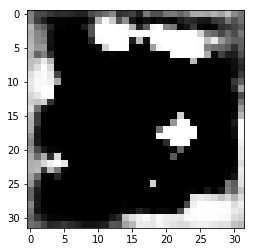

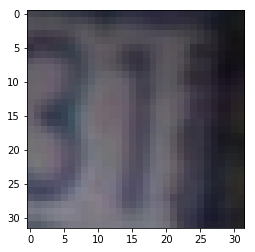

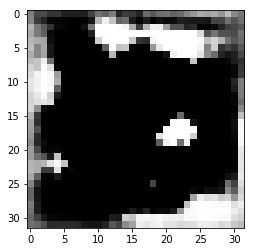

In [36]:
g_images = G.predict(svhn_train_X[:10])
for i in range(10):
    plt.figure()
    plt.imshow(svhn_train_X[i])
    plt.figure()
    plt.imshow(g_images[i][:, :, 0], cmap='gray')
D.predict(g_images)